# Two-stage approach + R_convexity

- In this notebook, I implemented the two-stage approach and incorporated Tim's R_convexity to calculate the KLLN model.
- I modified the model so that, under the two-stage approach, liquidity-unconstrained agents make deposits.
- This results in changes to the money demand function and aggregate deposit sections.
- Specifically, liquidity-unconstrained buyers now receive a marginal benefit of i, and the total deposits increase by the amount of idle cash held by unconstrained buyers.
- The code was adjusted to account for R_convexity, with a focus on using Rfit within the R() function. Additionally, to calculate dJ (or dF), Rfit.derivative()(rho) is utilized.

Other critical areas to check include adjustments considering the measure of active and non-active buyers:
- Money demand function
- Equilibrium outcome
- Loan/deposit market clearing condition

Please review these aspects carefully.

Additionally, I still feel that the modifications to the money demand function across the z_range may not be fully complete. In particular, it’s uncertain whether i_bound, among other factors, should also be considered. I’ll finalize this part once Tim completes the Lemma arrangements.

## SME: BJ goods and competitive banks 
Given policy $\tau$, we get real money balance $(z)$ and market interest rate $(i=i_{l}=i_{d})$ by solving

\begin{equation}
\begin{split}
z^{\star} \leftarrow  \frac{1+\tau -\beta}{\beta} &= R(z,i)
\\
i_{l}=i_{d}=i^{\star} \leftarrow (1-n) \cdot z + n \cdot \int^{\overline{\rho}}_{\hat{\rho}} [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \delta(i,\rho,z)\text{d}J(\rho)&= n \cdot \int^{\tilde{\rho}}_{\underline{\rho}} [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \xi(i,\rho,z) \text{d}J(\rho)
\end{split}
\label{eq:k-phi-high-type-case1}
\end{equation}

where
\begin{equation*}
\begin{split}
R(z,i) &:=  \color{blue}{(1-n)} \cdot i + \color{blue}{n}\bigg[\int^{\tilde{\rho}}_{\underline{\rho}} i [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \text{d}J(\rho)
\\
&+ \int^{\hat{\rho}}_{\tilde{\rho}} [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \bigg[\frac{1}{\rho}\bigg(\frac{z}{\rho}\bigg)^{-\sigma} -1 \bigg] \text{d}J(\rho)
\\
&+ \int^{\overline{\rho}}_{\hat{\rho}} [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \cdot i \text{d}J(\rho)\bigg]
\end{split}
\end{equation*}

* Two equations and two unknowns 

In [1]:
import bcw_bj as main
import hlmw as hlmw
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import interpolate
from scipy.optimize import brentq, fsolve
#import tikzplotlib
import time

In [2]:
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'

In [3]:
font = {'family' : 'serif','weight':'normal',
        'size'   : 10}
plt.rc('font', **font)

In [4]:
model = main.baseline_mod(σ_DM=0.6, Ubar_CM=1.9, n=0.7,τ_max = 0.05,τgrid_size = 30,N_reimann = 1000)
#model_1 = main.baseline_mod(σ_DM=0.6, Ubar_CM=1.9, n=0.8,τ_max = 0.01,τgrid_size = 7,N_reimann = 500)
#model_2 = main.baseline_mod(σ_DM=0.6, Ubar_CM=1.9, n=0.7,τ_max = 0.01,τgrid_size = 7,N_reimann = 500)
#model_3 = main.baseline_mod(σ_DM=0.6, Ubar_CM=1.9, n=0.6,τ_max = 0.01,τgrid_size = 7,N_reimann = 500)
#model_4 = main.baseline_mod(σ_DM=0.6, Ubar_CM=1.9, n=0.5,τ_max = 0.01,τgrid_size = 7,N_reimann = 500)
#model_5 = main.baseline_mod(σ_DM=0.6, Ubar_CM=1.9, n=0.4,τ_max = 0.01,τgrid_size = 7,N_reimann = 500)
#model_6 = main.baseline_mod(σ_DM=0.6, Ubar_CM=1.9, n=0.3,τ_max = 0.01,τgrid_size = 7,N_reimann = 500)

model_hlmw =hlmw.hlmw_mod(σ_DM=0.6, Ubar_CM=1.9, n=0.7,τ_max = 0.05,τgrid_size = 30,N_reimann = 1000)
#model_hlmw_1 =hlmw.hlmw_mod(σ_DM=0.6, Ubar_CM=1.9, n=0.8,τ_max = 0.01,τgrid_size = 7,N_reimann = 500)
#model_hlmw_2 =hlmw.hlmw_mod(σ_DM=0.6, Ubar_CM=1.9, n=0.7,τ_max = 0.01,τgrid_size = 7,N_reimann = 500)
#model_hlmw_3 =hlmw.hlmw_mod(σ_DM=0.6, Ubar_CM=1.9, n=0.6,τ_max = 0.01,τgrid_size = 7,N_reimann = 500)
#model_hlmw_4 =hlmw.hlmw_mod(σ_DM=0.6, Ubar_CM=1.9, n=0.5,τ_max = 0.01,τgrid_size = 7,N_reimann = 500)
#model_hlmw_5 =hlmw.hlmw_mod(σ_DM=0.6, Ubar_CM=1.9, n=0.4,τ_max = 0.01,τgrid_size = 7,N_reimann = 500)
#model_hlmw_6 =hlmw.hlmw_mod(σ_DM=0.6, Ubar_CM=1.9, n=0.3,τ_max = 0.01,τgrid_size = 7,N_reimann = 500)

### Example 0

* Solve system of two equations, given $\tau=0$

In [5]:
z_guess = 0.5
i_guess = 0.01
τ = 0

tic = time.time()
z, i = model.solve_z_i(z_guess, i_guess, τ) 
toc = time.time() - tic
print(z, i, toc)

0.5
0.01
0.5
0.01
0.5
0.01
0.5000000074505806
0.01
0.5
0.010000000149011612
0.6240415066430295
0.02016220983903879
0.6223028523793512
0.020172747393653764
0.6222743494141857
0.02017260893932485
0.6222743585895765
0.020172604464947074
0.6222743585895765 0.020172604464947074 511.6562571525574


### Example 0: few more check

In [6]:
### Check market clearing
Excess_loan_demand = model.Total_loan_func(i, z, τ) - model.Total_deposit_func(i, z, τ)
Excess_loan_demand

2.683911426437646e-10

In [7]:
### Check i_star vs. i_policy
print(i - model.i_policy(τ) )

0.00018076439966764266


In [8]:
### Check where different initial guesses will give the same answer

z_guess1 = 0.6
i_guess1 = 0.0185
τ = 0.0

tic = time.time()
z, i = model.solve_z_i(z_guess1, i_guess1, τ) # system of two equations given zero inflation
toc = time.time() - tic
print(z, i, toc)

0.6
0.0185
0.6
0.0185
0.6
0.0185
0.6000000089406967
0.0185
0.6
0.01850000027567148
0.6222814535864504
0.02016820612376401
0.6222743301491052
0.020172603515076354
0.6222743587924237
0.02017260445235254
0.6222743587924237 0.02017260445235254 444.8037950992584


* Different initial guess still give the same answer
* Loan market clears
* Equilibrium (market) loan rate is higher than the BCW case ($i=(1+\tau-\beta)/\beta)$

### Example 0: continues

* Solve system of two equations, given $\tau=0.05$

In [9]:
τ_1 = 0.05

tic = time.time()
z_1, i_1 = model.solve_z_i(z_guess, i_guess, τ_1) 
toc = time.time() - tic
print(z_1, i_1, toc)

0.5
0.01
0.5
0.01
0.5
0.01
0.5000000074505806
0.01
0.5
0.010000000149011612
0.570172659287524
0.0715964120112544
0.5684727062434288
0.07174920077846464
0.568461793080734
0.07174827234602896
0.5684616335432041
0.07174825454069797
0.5684616335432041 0.07174825454069797 504.98130893707275


In [10]:

### Check market clearing
Excess_loan_demand = model.Total_loan_func(i_1, z_1, τ_1) - model.Total_deposit_func(i_1, z_1, τ_1)
Excess_loan_demand

-3.7684277920391196e-10

In [11]:
ρ_grid = np.linspace(model.ρ_min_func(z, i, τ), model.ρ_max_func(z,i), 1000)
ρ_grid1 = np.linspace(model.ρ_min_func(z_1, i_1, τ_1), model.ρ_max_func(z_1,i_1), 1000)

In [12]:
ξ = [model.ξ_demand_func(ρ, i, z) for ρ in ρ_grid]
ξ1 = [model.ξ_demand_func(ρ, i_1, z_1) for ρ in ρ_grid1]

In [13]:
ρq = [model.q_expenditure(ρ, i, z) for ρ in ρ_grid]
ρq1 = [model.q_expenditure(ρ, i_1, z_1) for ρ in ρ_grid1]

In [14]:
F = [model.F_func(ρ, i, z,τ) for ρ in ρ_grid]
F1 = [model.F_func(ρ, i_1, z_1,τ_1) for ρ in ρ_grid1]

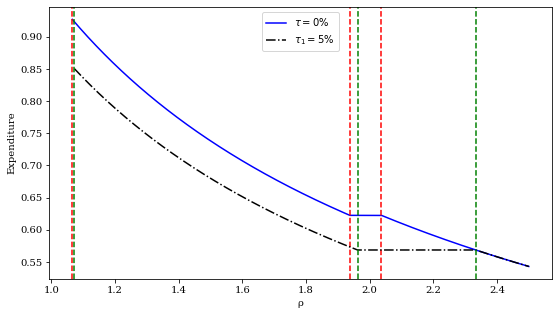

In [15]:
#plt.style.use(style='default')
plt.figure(facecolor='white', figsize=(9,5))
plt.plot(ρ_grid, ρq, color='blue', label=r"$\tau=0\%$")
plt.axvline(model.ρ_min_func(z, i, τ), linestyle='--', color='red')
plt.axvline(model.ρ_tilde_func(z, i), linestyle='--', color='red')
#plt.text(1.12, 0.6, r"$\tilde{\rho}_{i}(\tau)$",color='red')
plt.axvline(model.ρ_hat_func(z), linestyle='--', color='red')
#plt.text(1.185, 0.6, r"$\hat{\rho}(\tau)$",color='red')
### inflation at 5%
plt.plot(ρ_grid1, ρq1, '-.', color='black', label=r"$\tau_{1}=5\%$")
plt.axvline(model.ρ_min_func(z_1, i_1, τ_1), linestyle='--', color='green')
plt.axvline(model.ρ_tilde_func(z_1, i_1), linestyle='--', color='green')
#plt.text(1.15, 0.45, r"$\tilde{\rho}_{i}(\tau_{1})$",color='green')
plt.axvline(model.ρ_hat_func(z_1), linestyle='--', color='green')
#plt.text(1.31, 0.45, r"$\hat{\rho}(\tau_{1})$",color='green')
plt.ylabel('Expenditure')
plt.xlabel('ρ')
plt.legend()
plt.savefig("dm_expenditure.png", bbox_inches='tight', pad_inches=0.05)
plt.show()


#tikzplotlib.save("dm_expenditure.tex")
#tikzplotlib.save("dm_expenditure.pgf")


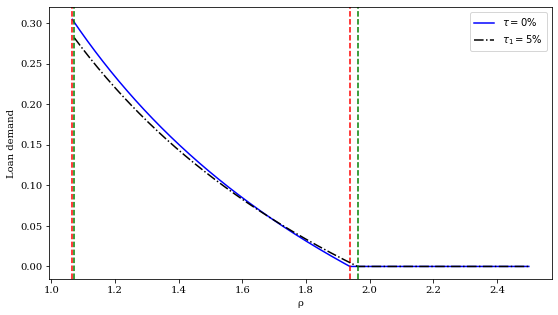

In [16]:
#plt.style.use(style='default')
plt.figure(facecolor='white', figsize=(9,5))
plt.plot(ρ_grid, ξ, color='blue', label=r"$\tau=0\%$")
plt.axvline(model.ρ_min_func(z, i, τ), linestyle='--', color='red')
plt.axvline(model.ρ_tilde_func(z, i), linestyle='--', color='red')
#plt.text(1.125, 0.08, r"$\tilde{\rho}_{i}(\tau)$",color='red')
plt.plot(ρ_grid1, ξ1, '-.', color='black', label=r"$\tau_{1}=5\%$")
plt.axvline(model.ρ_min_func(z_1, i_1, τ_1), linestyle='--', color='green')
plt.axvline(model.ρ_tilde_func(z_1, i_1), linestyle='--', color='green')
#plt.text(1.18, 0.1, r"$\tilde{\rho}_{i}(\tau_{1})$",color='green')
plt.ylabel('Loan demand')
plt.xlabel('ρ')
plt.legend()
plt.savefig("dm_loan.png", bbox_inches='tight', pad_inches=0.05)
plt.show()


#tikzplotlib.save("dm_loan.tex")
#tikzplotlib.save("dm_loan.pgf")

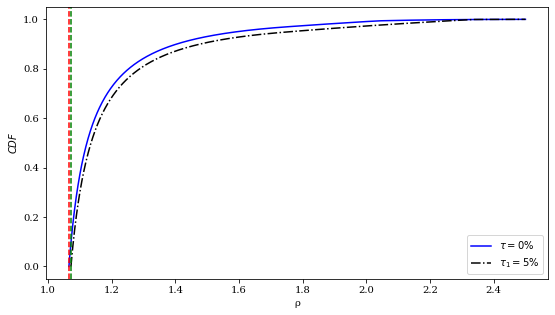

In [17]:
#plt.style.use(style='default')
plt.figure(facecolor='white', figsize=(9,5))
plt.plot(ρ_grid, F, color='blue', label=r"$\tau=0\%$")
plt.axvline(model.ρ_min_func(z, i, τ), linestyle='--', color='red')
plt.plot(ρ_grid1, F1, '-.', color='black', label=r"$\tau_{1}=5\%$")
plt.axvline(model.ρ_min_func(z_1, i_1, τ_1), linestyle='--', color='green')
plt.ylabel("$CDF$")
plt.xlabel("ρ")
plt.legend()
plt.savefig("cdf.png", bbox_inches='tight', pad_inches=0.05)
plt.show()


#tikzplotlib.save("cdf.tex")
#tikzplotlib.save("cdf.pgf")

### Example 1: Baseline vs. HLMW given $\tau = 0$


In [18]:
# Recall: baseline z and i, given τ = 0.0
z,i

(0.6222743587924237, 0.02017260445235254)

In [19]:
z_hlmw = model_hlmw.z_solver(τ)
z_hlmw

0.8873647413376011

In [20]:
ρ_grid_hlmw = np.linspace(model_hlmw.ρ_min_func(z_hlmw, τ), model_hlmw.ρ_max_func(z_hlmw), 1000)

ρq_hlmw = [model_hlmw.q_expenditure(ρ, z_hlmw) for ρ in ρ_grid_hlmw]
F_hlmw = [model_hlmw.F_func(ρ, z_hlmw) for ρ in ρ_grid_hlmw]


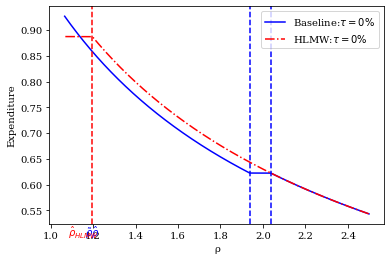

In [21]:
#plt.style.use(style='default')
plt.figure(facecolor='white')
plt.plot(ρ_grid, ρq, color='blue', label="Baseline:" r"$\tau=0\%$")
#plt.axvline(model.ρ_min_func(z, i, τ), linestyle='--', color='blue')
plt.axvline(model.ρ_tilde_func(z, i), linestyle='--', color='blue')
plt.text(1.16, 0.5, r"$\tilde{\rho}_{i}$",color='blue')
plt.axvline(model.ρ_hat_func(z), linestyle='--', color='blue')
plt.text(1.19, 0.5, r"$\hat{\rho}$", color='blue')
plt.plot(ρ_grid_hlmw, ρq_hlmw, '-.', color='red', label="HLMW:" r"$\tau=0\%$")
#plt.axvline(model_hlmw.ρ_min_func(z_hlmw, τ), linestyle='--', color='orange')
plt.axvline(model_hlmw.ρ_hat_func(z_hlmw), linestyle='--', color='red')
plt.text(1.08, 0.5, r"$\hat{\rho}_{HLMW}$", color='red')
plt.ylabel('Expenditure')
plt.xlabel('ρ')
plt.legend()
plt.savefig("klln_hlmw_expenditure.png", bbox_inches='tight', pad_inches=0.05)
plt.show()


#tikzplotlib.save("klln_hlmw_expenditure.tex")
#tikzplotlib.save("klln_hlmw_expenditure.pgf")


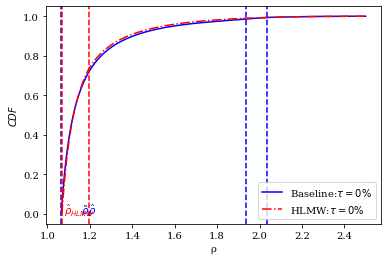

In [22]:
#plt.style.use(style='default')
plt.figure(facecolor='white')
plt.plot(ρ_grid, F, color='blue', label="Baseline:" r"$\tau=0\%$")
plt.axvline(model.ρ_min_func(z, i, τ), linestyle='--', color='blue')
plt.plot(ρ_grid_hlmw, F_hlmw, '-.', color='red', label="HLMW:" r"$\tau=0\%$")
plt.axvline(model_hlmw.ρ_min_func(z_hlmw, τ), linestyle='--', color='red')

plt.axvline(model.ρ_tilde_func(z, i), linestyle='--', color='blue')
plt.text(1.16, 0.0, r"$\tilde{\rho}_{i}$",color='blue')
plt.axvline(model.ρ_hat_func(z), linestyle='--', color='blue')
plt.text(1.19, 0.0, r"$\hat{\rho}$", color='blue')

#plt.axvline(model_hlmw.ρ_min_func(z_hlmw, τ), linestyle='--', color='orange')
plt.axvline(model_hlmw.ρ_hat_func(z_hlmw), linestyle='--', color='red')
plt.text(1.08, 0.0, r"$\hat{\rho}_{HLMW}$", color='red')

plt.ylabel(r"$CDF$")
plt.xlabel("ρ")
plt.legend()
plt.savefig("klln_hlmw_cdf.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

### SME: HLMW + perfectly competitive banks (Baseline)

* Vary $\tau \in [\beta-1, 0.1]$

In [ ]:
z_guess = 0.4
i_guess = 0.01
result = model.SME_stat(z_guess, i_guess) # this uses fsolve
#result_1 = model_1.SME_stat(z_guess, i_guess) # this uses fsolve
#result_2 = model_2.SME_stat(z_guess, i_guess) # this uses fsolve
#result_3 = model_3.SME_stat(z_guess, i_guess) # this uses fsolve
#result_4 = model_4.SME_stat(z_guess, i_guess) # this uses fsolve
#result_5 = model_5.SME_stat(z_guess, i_guess) # this uses fsolve
#result_6 = model_6.SME_stat(z_guess, i_guess) # this uses fsolve

-0.01959999999999995
-0.01719999999999995
0.4
0.01
0.4
0.01
0.4
0.01
0.4000000059604645
0.01
0.4
0.010000000149011612
0.6425723845232127
0.0024688452869024036
0.6424153979883356
0.002468963283753336
0.6424152874369488
0.0024689416377727787
-0.014799999999999954
0.4
0.01
0.4
0.01
0.4
0.01
0.4000000059604645
0.01
0.4
0.010000000149011612
0.6399866818288212
0.004937686852316898
0.6395519900431089
0.004938177216237752
0.6395509860153339
0.004938136441491288
-0.012399999999999956
0.4
0.01
0.4
0.01
0.4
0.01
0.4000000059604645
0.01
0.4
0.010000000149011612
0.6374009791344301
0.007406528417731168
0.6367072192163733
0.007407681999716365
0.6367045786438348
0.00740763336620808
-0.009999999999999957
0.4
0.01
0.4
0.01
0.4
0.01
0.4000000059604645
0.01
0.4
0.010000000149011612
0.6348152764400385
0.009875369983145662
0.6338805820079622
0.009877613523787625
0.6338756442816248
0.009877583326007886
0.6338756452113176
0.009877583272973056
-0.0075999999999999575
0.4
0.01
0.4
0.01
0.4
0.01
0.400000005960464

In [ ]:
z = result['allocation_grid']['zstar']
q = result['allocation_grid']['qstar']
ξ = result['allocation_grid']['ξstar']
i = result['allocation_grid']['istar']
DM_surplus = result['allocation_grid']['DM_surplus']
W = result['allocation_grid']['w_star']
W_BCW = result['allocation_grid']['w_bcw']

mpy = result['stat_grid']['mpy_star']
markup = result['stat_grid']['markup_mean']
markup_cv = result['stat_grid']['markup_cv']
loan_gdp = result['stat_grid']['credit_gdp']
loan_gdp_bcw = result['stat_grid']['credit_gdp_bcw']

### HLMW: without banks

In [ ]:
result_hlmw = model_hlmw.SME_stat() # this uses brentq only
#result_hlmw_1 = model_hlmw_1.SME_stat() # this uses brentq only
#result_hlmw_2 = model_hlmw_2.SME_stat() # this uses brentq only
#result_hlmw_3 = model_hlmw_3.SME_stat() # this uses brentq only
#result_hlmw_4 = model_hlmw_4.SME_stat() # this uses brentq only
#result_hlmw_5 = model_hlmw_5.SME_stat() # this uses brentq only
#result_hlmw_6 = model_hlmw_6.SME_stat() # this uses brentq only

In [ ]:
z_hlmw = result_hlmw['allocation_grid']['zstar']
q_hlmw = result_hlmw['allocation_grid']['qstar']
W_hlmw = result_hlmw['allocation_grid']['w_star']
DM_surplus_hlmw = result_hlmw['allocation_grid']['DM_surplus']

mpy_hlmw = result_hlmw['stat_grid']['mpy_star']
markup_hlmw = result_hlmw['stat_grid']['markup_mean']
markup_cv_hlmw = result_hlmw['stat_grid']['markup_cv']

In [ ]:
τ_grid = model.τ_grid # inflation rate grid
i_grid = model.i_policy(τ_grid)

In [ ]:
font = {'family' : 'serif','weight':'normal',
        'size'   : 10}
plt.rc('font', **font)

### Difference welfare

* Comparision 1: $DW_{1}:= W_{Baseline} - W_{HLMW}$
    * Baseline economy: Price dispersion + perfectly competitive banks 
    * HLMW: Price dispersion
    * This shows the welfare gains/losses by isolating effects of **banking** only
    
    
* Comparision 2: $DW_{2}:= W_{BCW} -  W_{Baseline}$
    * Baseline economy: Price dispersion + perfectly competitive banks 
    * BCW: Competitive pricing + perfectly competitive banks
    * This shows the welfare gains/losses by isolating effects of **price dispersion** only
    
    
* Comparision 3: $DW_{3}:= W_{BCW} - W_{HLMW}$
    * HLMW: Price dispersion
    * BCW: Competitive pricing + perfectly competitive banks
    * This shows the welfare gains/losses by having both effects of **price dispersion** and **banking**

In [ ]:
W = result['allocation_grid']['w_star']
W_hlmw = result_hlmw['allocation_grid']['w_star']

In [ ]:
DW = W - W_hlmw # Baseline vs. HLMW
DW_2 = W_BCW - W # BCW vs. Baseline
DW_3 = W_BCW - W_hlmw # BCW vs. HLMW

In [ ]:
#plt.style.use(style='default')
plt.figure(facecolor='white')
plt.plot(i_grid*100, DW, label='Baseline vs. HLMW',color='r')
plt.axhline(y=0,color="black", linestyle='--',linewidth=1.0)
plt.ylabel("DW")
plt.xlabel("Nominal interest rate (%)")
plt.legend()
plt.savefig("DW.png")
plt.show()


#tikzplotlib.save("DW.tex")
#tikzplotlib.save("DW.pgf")

In [ ]:
plt.rcParams['font.family'] = 'serif'

In [ ]:
#plt.style.use(style='default')
plt.figure(facecolor='white')
plt.plot(i_grid*100, DW, color='blue', label='Baseline vs. HLMW')
plt.plot(i_grid*100, DW_2, '--', color='green', label='BCW vs. Baseline')
plt.plot(i_grid*100, DW_3, '--.', color='orange', label='BCW vs. HLMW')
#plt.plot(i_grid*100, np.zeros(DW.size))
plt.axhline(y=0,color="black", linestyle='--',linewidth=1.0)
plt.ylabel("$DW$")
plt.xlabel("Nominal interest rate (%)")
plt.legend()
plt.savefig("dw_all.png")

plt.show()

In [ ]:
def gap_percent_func(delta_W_bank, W_no_bank):
    """Use this function to calculate CEV"""
    n_point = 60
    delta = np.append(np.linspace(2, 1, round(n_point/2), endpoint=False), (np.linspace(1, 0.1, round(n_point/2))))
    gap_welfare = delta_W_bank - W_no_bank
    interp_fn = interpolate.interp1d(delta, gap_welfare, 'cubic')
    interp_fn2 = lambda x: interp_fn(x) - 0.0
    gap_delta = brentq(interp_fn2, delta.min(), delta.max())
    cev = (1.0 - gap_delta) * 100
    return cev

In [ ]:
def calculate_cev_percent(τ, z_guess, i_guess, case='Case1'):
    n_point = 60
    delta = np.append(np.linspace(2, 1, round(n_point/2), endpoint=False), (np.linspace(1, 0.1, round(n_point/2))))

    # klln
    z, i = model.solve_z_i(z_guess, i_guess, τ)

    # hlmw
    z_hlmw = model_hlmw.z_solver(τ)
    
    # Welfare increases by delta
    if case == 'Case1':
        delta_klln = [model.welfare_func_delta(z, i, τ, k) for k in delta]
            
    elif case == 'Case2':
        delta_bcw = [model.welfare_bcw_func_delta(τ, k) for k in delta]
            
    elif case == 'Case3':
        delta_bcw = [model.welfare_bcw_func_delta(τ, k) for k in delta]

    ### HLMW
    welfare_hlmw = model_hlmw.welfare_func(z_hlmw, τ)
    
    ### Baseline
    welfare_klln = model.welfare_func(z, i, τ)
    
    ### BCW
    welfare_bcw = model.welfare_bcw_func(τ)
    
    if case == 'Case1':
        cev_percent = gap_percent_func(delta_klln, welfare_hlmw)
        
    elif case == 'Case2':
        cev_percent = gap_percent_func(delta_bcw, welfare_klln)
        
    elif case == 'Case3':
        cev_percent = gap_percent_func(delta_bcw, welfare_hlmw)
  

    return cev_percent


In [ ]:
Case1_cev = [calculate_cev_percent(j, z_guess, i_guess, case='Case1') for j in τ_grid ]

In [ ]:
Case2_cev = [calculate_cev_percent(j, z_guess, i_guess, case='Case2') for j in τ_grid ]

In [ ]:
Case3_cev = [calculate_cev_percent(j, z_guess, i_guess, case='Case3') for j in τ_grid ]

In [ ]:

plt.figure(facecolor='white')
plt.plot(i_grid*100, Case1_cev, label='Baseline vs. HLMW',color='r')
plt.axhline(y=0,color="black", linestyle='--',linewidth=1.0)
plt.ylabel("$CEV$")
plt.xlabel("Nominal interest rate (%)")
plt.legend()
plt.savefig("cev.png")
plt.show()


In [ ]:
#plt.style.use(style='default')
plt.figure(facecolor='white')
plt.plot(i_grid*100, Case1_cev, color='blue', label='Baseline vs. HLMW')
plt.plot(i_grid*100, Case2_cev, '--', color='green', label='BCW vs. Baseline')
plt.plot(i_grid*100, Case3_cev, '--.', color='orange', label='BCW vs. HLMW')
plt.plot(i_grid*100, np.zeros(τ_grid.size))
plt.ylabel("$CEV$")
plt.xlabel("Nominal interest rate (%)")
plt.legend()
plt.savefig("cev_all.png")
plt.show()

In [ ]:
#plt.style.use(style='default')
plt.figure(facecolor='white')
plt.plot(i_grid[1:]*100, markup[1:], color='blue', label='Baseline') #exclude FR
plt.plot(i_grid[1:]*100, markup_hlmw[1:], '-.', color='red', label='HLMW') #exclude FR
plt.ylabel(r'$μ$')
plt.xlabel("Nominal interest rate (%)")
plt.legend()
#plt.yticks(np.arange(1.15,1.41, 0.05))
#plt.xlim(-0.5,10)
plt.savefig("markup.png", bbox_inches='tight', pad_inches=0.05)
plt.show()


#tikzplotlib.save("markup.tex")
#tikzplotlib.save("markup.pgf")

In [ ]:
#plt.style.use(style='default')
plt.figure(facecolor='white')
plt.plot(i_grid[1:]*100, z[1:], color='blue', label='Baseline') #exclude FR
plt.plot(i_grid[1:]*100, z_hlmw[1:], '-.', color='red', label='HLMW') #exclude FR
plt.ylabel(r'$μ$')
plt.xlabel("Nominal interest rate (%)")
plt.legend()
#plt.yticks(np.arange(1.15,1.41, 0.05))
#plt.xlim(-0.5,10)
plt.savefig("real_balance.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

In [ ]:
#plt.style.use(style='default')
plt.figure(facecolor='white')
plt.plot(i_grid[1:]*100, q[1:], color='blue', label='Baseline') #exclude FR
plt.plot(i_grid[1:]*100, q_hlmw[1:], '-.', color='red', label='HLMW') #exclude FR
plt.ylabel(r'$μ$')
plt.xlabel("Nominal interest rate (%)")
plt.legend()
#plt.yticks(np.arange(1.15,1.41, 0.05))
#plt.xlim(-0.5,10)
plt.savefig("DM_good.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

In [ ]:
#plt.style.use(style='default')
plt.figure(facecolor='white')
plt.plot(i_grid[1:]*100, markup_cv[1:], color='blue', label='Baseline') #exclude FR
plt.plot(i_grid[1:]*100, markup_cv_hlmw[1:], '-.', color='red', label='HLMW') #exclude FR
plt.ylabel(r'$CV_{μ}$')
plt.xlabel("Nominal interest rate (%)")
plt.legend()
#plt.xlim(-0.5,10)
plt.savefig("markup_cv.png", bbox_inches='tight', pad_inches=0.05)
plt.show()


#tikzplotlib.save("markup_cv.tex")
#tikzplotlib.save("markup_cv.pgf")

In [ ]:
#plt.style.use(style='default')
plt.figure(facecolor='white')
plt.plot(i_grid[1:]*100, loan_gdp[1:], color='blue', label='Baseline') #exclude FR
plt.plot(i_grid[1:]*100, loan_gdp_bcw[1:], '--.', color='orange', label='BCW') #exclude FR
plt.ylabel('Loan-to-GDP')
plt.xlabel("Nominal interest rate (%)")
plt.legend()
plt.savefig("loan_gdp.png", bbox_inches='tight', pad_inches=0)
plt.show()


#tikzplotlib.save("loan_gdp.tex")
#tikzplotlib.save("loan_gdp.pgf")

In [ ]:
##### ZOOM-IN

##### plt.style.use(style='default')
plt.figure(facecolor='white')
# Initialize a flag to indicate when the label has been added
label_added_red = False
label_added_blue = False

for i in range(1, len(i_grid[0:60])):
    if Case1_cev[i-1] <= 0 and Case1_cev[i] > 0 or Case1_cev[i-1] > 0 and Case1_cev[i] > 0:
        # This segment is positive, plot in blue
        if not label_added_blue:
            plt.plot(i_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='blue', linestyle=':', label='Baseline vs. HLMW')
            label_added_blue = True
        else:
            plt.plot(i_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='blue', linestyle=':')
    else:
        # This segment is not positive, plot in dark red
        if not label_added_red:
            plt.plot(i_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='darkred', linestyle=':')
            label_added_red = True
        else:
            plt.plot(i_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='darkred', linestyle=':')


#plt.plot(i_grid[0:10]*100, np.zeros(τ_grid[0:30].size))
plt.ylabel("$CEV$")
plt.xlabel("Nominal interest rate (%)")
plt.legend()
plt.axhline(y=0,color="black", linestyle='--',linewidth=1.0)
plt.fill_between(i_grid[0:60]*100, Case1_cev[0:60], where=(np.array(Case1_cev)[0:60] <= 0), color='peachpuff', alpha=0.1, interpolate=True)
plt.fill_between(i_grid[0:60]*100, Case1_cev[0:60], where=(np.array(Case1_cev)[0:60] >= 0), color='#B0E0E6', alpha=0.1, interpolate=True)
plt.text(0.3, -0.007, 'Negative(-)',size=10,color='red')
plt.text(2.7, 0.01, 'Positive(+)',size=10,color='blue')
#plt.ylim(-0.01,0.04)
plt.savefig("cev_zoom_in.png", bbox_inches='tight', pad_inches=0.05)
plt.show()